In [1]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
df_main = pd.read_csv('/data/home/konstantin.parfenov/fetch.csv', delimiter=',')

#Меняем категории на чисельные значения
df_main['gender'] = df_main['gender'].map({'F': 0, 'M': 1})
df_main['age'] = df_main['age'].map({'18-24': 0, '25-34': 0.25, '35-44': 0.5,'45-54': 0.75, '>=55': 1 })

#отделяем тест от трейна
df_train = df_main.iloc[0:36138]
df_train.fillna(0, inplace = True)
df_test = df_main.iloc[36138:]

In [3]:
df_main['age'].unique()

array([0.  , 0.25, 1.  , 0.75, 0.5 ,  nan])

In [4]:
df_train.tail(10)

,gender,age,uid,авто и мото,автотовары,агрегаторы,бизнес,видео,государство и общество,для взрослых (18+),...,социальные сети,спорт и активный образ жизни,справочные ресурсы,стиль,строительство и ремонт,техника и технологии,торговля,услуги,финансы,цветы
36128,1.0,0.25,bd723a3c-4d87-49ae-be94-585905217995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,107.0,0.0,0.0,0.0
36129,0.0,0.75,bd72e63c-53b6-44fd-9366-e10cdae64951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
36130,0.0,0.25,bd72e796-3c60-4e80-84d8-40fae2c48ced,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,2.0,124.0,34.0,1.0,0.0
36131,1.0,0.25,bd743735-3307-43f1-9d69-6ceac5fe2111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
36132,0.0,0.50,bd760bb8-fcfa-4ec5-ae8f-b37f5bab72be,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36133,1.0,0.50,bd762af7-17cc-4309-be1b-357fce9e3d4b,0.0,0.0,0.0,2.0,0.0,4.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0
36134,1.0,0.25,bd78086e-4a6d-4e5b-b930-174f722ad661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,32.0,22.0,9.0,0.0,0.0
36135,1.0,0.25,bd783220-88f7-435b-a14d-6aeb07d7a53a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36136,1.0,0.00,bd79a9fa-34d1-46b3-8cf1-ddacd0b730a5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36137,1.0,0.25,bd79ac4b-c0e8-405b-a972-f4e88f7efadc,0.0,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,6.0,8.0,0.0,0.0,0.0


In [5]:
df_test.head(10)

,gender,age,uid,авто и мото,автотовары,агрегаторы,бизнес,видео,государство и общество,для взрослых (18+),...,социальные сети,спорт и активный образ жизни,справочные ресурсы,стиль,строительство и ремонт,техника и технологии,торговля,услуги,финансы,цветы
36138,NaN,NaN,bd7a30e1-a25d-4cbf-a03f-61748cbe540e,8.0,NaN,NaN,NaN,NaN,1.0,4.0,...,NaN,34.0,12.0,NaN,8.0,NaN,137.0,1.0,NaN,NaN
36139,NaN,NaN,bd7a6f52-45db-49bf-90f2-a3b07a9b7bcd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,559.0,29.0,7.0,NaN
36140,NaN,NaN,bd7a7fd9-ab06-42f5-bf0f-1cbb0463004c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36141,NaN,NaN,bd7c5d7a-0def-41d1-895f-fdb96c56c2d4,34.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
36142,NaN,NaN,bd7e54a2-0215-45cb-a869-9efebf250e38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
36143,NaN,NaN,bd7e9797-4cdb-46e1-a540-f3ea010605ad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36144,NaN,NaN,bd7e9ec7-fb67-45eb-8ad3-209d01d15ae6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36145,NaN,NaN,bd8056df-cc25-4b63-bc12-a46f888baa49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36146,NaN,NaN,bd818690-73d2-445d-be5d-5c8f748dbb19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36147,NaN,NaN,bd81e006-f059-4cdd-b716-3467c78d1312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [14]:
#get column names
column_headers = list(df_train.columns.values)
features_len = len(column_headers[3:])

In [15]:
X_train = df_train[column_headers[3:]]
#X_train

In [16]:
y_train = df_train['gender']

In [20]:
#Бинарная классификация для пола
model = Sequential()
#Указываем кол-во столбцов
model.add(Dense(32, activation='relu', input_dim = features_len))
model.add(Dense(1, activation ='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy','mae','cosine_proximity'])

Train on 28910 samples, validate on 7228 samples
Epoch 1/10
28910/28910 [==============================] - 4s 132us/step - loss: 1.0915 - acc: 0.5772 - mean_absolute_error: 0.4559 - cosine_proximity: -0.5123 - val_loss: 0.8490 - val_acc: 0.5955 - val_mean_absolute_error: 0.4475 - val_cosine_proximity: -0.5190
Epoch 2/10
28910/28910 [==============================] - 3s 118us/step - loss: 0.9175 - acc: 0.5941 - mean_absolute_error: 0.4482 - cosine_proximity: -0.5130 - val_loss: 0.8575 - val_acc: 0.5921 - val_mean_absolute_error: 0.4473 - val_cosine_proximity: -0.5195
Epoch 3/10
28910/28910 [==============================] - 10s 347us/step - loss: 0.8783 - acc: 0.5973 - mean_absolute_error: 0.4455 - cosine_proximity: -0.5141 - val_loss: 0.9849 - val_acc: 0.5571 - val_mean_absolute_error: 0.4659 - val_cosine_proximity: -0.5130
Epoch 4/10
28910/28910 [==============================] - 3s 114us/step - loss: 0.8518 - acc: 0.6043 - mean_absolute_error: 0.4433 - cosine_proximity: -0.5140 - val

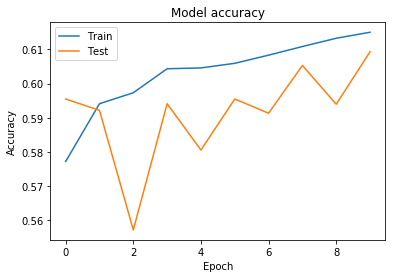

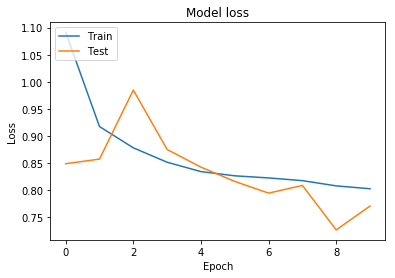

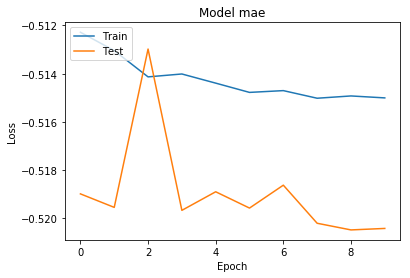

In [21]:
import matplotlib.pyplot as plt

batch_size = 32
epochs = 10
history = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['cosine_proximity'])
plt.plot(history.history['val_cosine_proximity'])
plt.title('Cosine_proximity')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Определение возрастной группы

In [35]:
X_age_train = df_train[column_headers[3:]]
y_age_train = df_train['age']

In [36]:
# model 5 classes (categorical classification):
# 
# Convert labels to categorical one-hot encoding - Вариант создания категорий из текста
# one_hot_labels = keras.utils.to_categorical(labels, num_classes=5)

y_age_train_mod = keras.utils.to_categorical(y_age_train, num_classes=5)

#Для себя надо внимательно прочитать про loss='sparse_categorical_crossentropy' и альтернативы


model_age = Sequential()
model_age.add(Dense(42, activation='relu', input_dim=features_len))
model_age.add(Dense(5, activation='sigmoid'))
model_age.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Epoch 1/20
36138/36138 [==============================] - 4s 107us/step - loss: 0.4121 - acc: 0.9234
Epoch 2/20
36138/36138 [==============================] - 4s 101us/step - loss: 0.2737 - acc: 0.9535
Epoch 3/20
36138/36138 [==============================] - 3s 95us/step - loss: 0.2715 - acc: 0.9535
Epoch 4/20
36138/36138 [==============================] - 4s 108us/step - loss: 0.2672 - acc: 0.9535
Epoch 5/20
36138/36138 [==============================] - 10s 279us/step - loss: 0.2622 - acc: 0.9535
Epoch 6/20
36138/36138 [==============================] - 4s 111us/step - loss: 0.2566 - acc: 0.9535
Epoch 7/20
36138/36138 [==============================] - 3s 92us/step - loss: 0.2458 - acc: 0.9535
Epoch 8/20
36138/36138 [==============================] - 4s 106us/step - loss: 0.2397 - acc: 0.9535
Epoch 9/20
36138/36138 [==============================] - 4s 118us/step - loss: 0.2390 - acc: 0.9535
Epoch 10/20
36138/36138 [==============================] - 6s 161us/step - loss: 0.2340 - ac

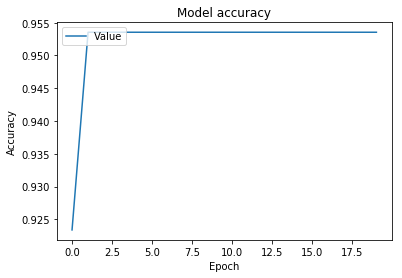

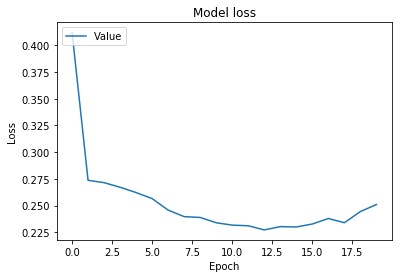

In [37]:
history_age = model_age.fit(X_age_train, y_age_train_mod, epochs=20, batch_size=32, verbose=1)

# Plot training & validation accuracy values
plt.plot(history_age.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_age.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

Определение возрастной группы  метод_2

In [26]:
X_age_train = df_train[column_headers[3:]]
y_age_train = df_train['age']

In [33]:
model_age2 = Sequential()
model_age2.add(Dense(42, activation='relu', input_dim=features_len))
model_age2.add(Dense(1, activation='sigmoid'))
model_age2.compile(optimizer='sgd',
              loss='cosine_proximity',
              metrics=['accuracy','top_k_categorical_accuracy'])

Epoch 1/10
36138/36138 [==============================] - 4s 100us/step - loss: -0.8619 - acc: 0.0527 - top_k_categorical_accuracy: 1.0000
Epoch 2/10
36138/36138 [==============================] - 4s 106us/step - loss: -0.8642 - acc: 0.0484 - top_k_categorical_accuracy: 1.0000
Epoch 3/10
36138/36138 [==============================] - 4s 104us/step - loss: -0.8643 - acc: 0.0483 - top_k_categorical_accuracy: 1.0000
Epoch 4/10
36138/36138 [==============================] - 10s 279us/step - loss: -0.8643 - acc: 0.0483 - top_k_categorical_accuracy: 1.0000
Epoch 5/10
36138/36138 [==============================] - 4s 110us/step - loss: -0.8643 - acc: 0.0483 - top_k_categorical_accuracy: 1.0000
Epoch 6/10
36138/36138 [==============================] - 4s 104us/step - loss: -0.8645 - acc: 0.0479 - top_k_categorical_accuracy: 1.0000
Epoch 7/10
36138/36138 [==============================] - 4s 102us/step - loss: -0.8645 - acc: 0.0479 - top_k_categorical_accuracy: 1.0000
Epoch 8/10
36138/36138 [==

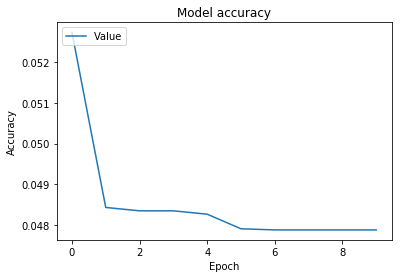

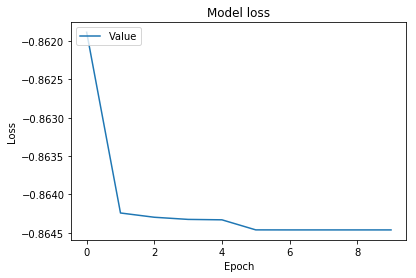

In [34]:
history_age2 = model_age2.fit(X_age_train, y_age_train, epochs=10, batch_size=32, verbose=1)

# Plot training & validation accuracy values
plt.plot(history_age2.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_age2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Value'], loc='upper left')
plt.show()